In [1]:
from utils.data_handling import *
from utils.sensor_optimisation_tsvd import *
from parameters import *
import GPy
import scipy.stats

import matplotlib.pyplot as plt
np.random.seed(101)



### Importing the Tracer Data to Select the Optimisation set S

In [2]:
parameters['field_name'] = "Tracer"
parameters


{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [3]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


### Working subset of the data : set S

In [4]:
S_human = human_level_subset(buildingshape, loc_df, 2,1 )
print("The remaining number of points is : ", str(len(S_human)))

The remaining number of points is :  37847


In [5]:
S_working = working_subset(data_df, loc_df, nbins = (25,25,25), threshold_sum = 10**-2 )
print("The remaining number of points is : ", str(len(S_working)))

The remaining number of points is :  57725


In [6]:
S = np.intersect1d(S_human,S_working)
print("The remaining number of points is : ", str(len(S)))

The remaining number of points is :  23643


In [7]:
#A_list = set_to_onehot(S_working,data_df.shape[0])
#save_vtu(ref_vtu[0],'S_working_10^-2',A_list)

### Import the Field of interest for computing the optimisation : TracerBackground / Pressure

In [8]:
parameters['i_end'] = 988
parameters['field_name'] = "Tracer"
parameters


{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [9]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


In [10]:
X = loc_df.values[:,:] #[I,:dim]
Z = data_df.values[:,:]#[:,t].reshape(-1,1) # [I,t].reshape(-1,1)
Z.shape

(100040, 989)

### Detrending Data : 
Plotting the data along each direction in order to see if there is a obvious trend. It seams that it is not the case. 

In [11]:
Z[S,:] = (Z[S,:]  - Z[S,:].mean(axis=1,keepdims=True))

PCA tests

In [12]:
from sklearn.decomposition import PCA

from sklearn.covariance import *


In [13]:
model = GraphicalLasso(
    alpha=0.01,
    mode='cd',
    tol=0.0001,
    enet_tol=0.0001,
    max_iter=100,
    verbose=True,
    assume_centered=False)

In [ ]:
model.fit(Z[S,:].T)

In [ ]:
model.covariance_.shape

## Empirical


In [14]:
cov_emp = empirical_covariance(Z[S,:].T)
cov_emp.shape

(23643, 23643)

In [15]:
print(np.linalg.slogdet(cov_emp))

(-1.0, -1399936.2860277274)


In [16]:
eig_emp = np.linalg.eigvalsh(cov_emp)

Text(0, 0.5, 'Eigenvalues $\\lambda_i$')

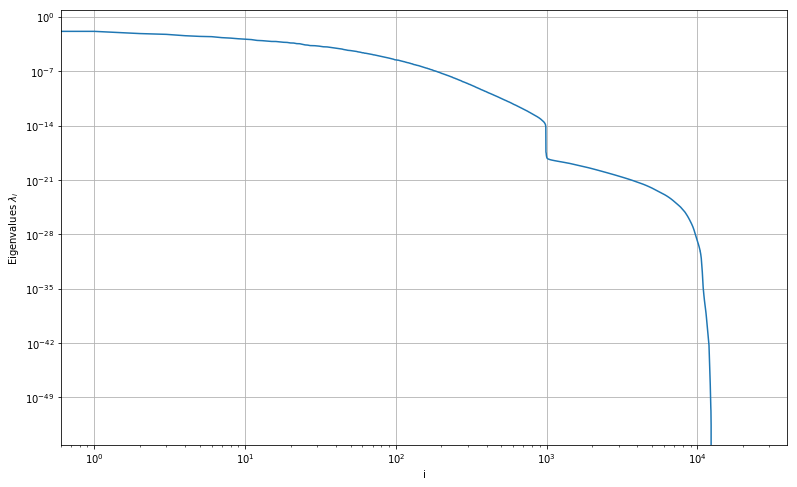

In [17]:
plt.figure(figsize=(13,8))
plt.loglog(eig_emp[::-1])
plt.grid()
plt.xlabel("i")
plt.ylabel("Eigenvalues $\lambda_i$")

## Ledoit Lewolf

In [34]:
model = LedoitWolf()
model.fit(Z[S,:].T)
cov_ledoit = model.covariance_


In [35]:
model.shrinkage_

0.009781059248793703

In [96]:
np.linalg.slogdet(cov_ledoit)

(1.0, -406320.1974914403)

In [36]:
eig_ledoit = np.linalg.eigvalsh(cov_ledoit)


In [103]:
eig_ledoit[0]

3.286765546982222e-08

Text(0, 0.5, 'Eigenvalues $\\lambda_i$')

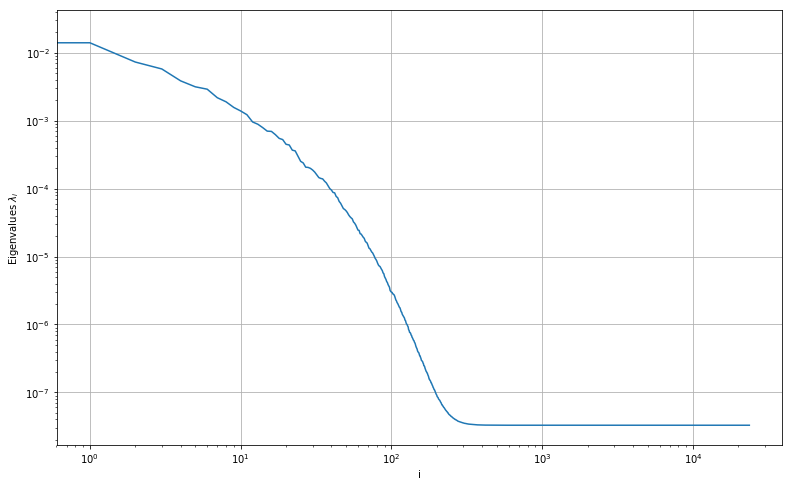

In [35]:
plt.figure(figsize=(13,8))
plt.loglog(eig_ledoit[::-1])
plt.grid()
plt.xlabel("i")
plt.ylabel("Eigenvalues $\lambda_i$")

## OAS

In [41]:
cov_oas = oas(Z[S,:].T)
cov_oas[0].shape

(23643, 23643)

In [42]:
cov_oas[0]

array([[ 2.94410328e-08,  8.34050388e-15, -1.26981376e-09, ...,
        -4.40232159e-23, -6.59736285e-26, -8.84706691e-26],
       [ 8.34050388e-15,  2.94350276e-08, -7.73020912e-12, ...,
         2.87754370e-24, -1.02917247e-27, -1.07849477e-27],
       [-1.26981376e-09, -7.73020912e-12,  2.18794450e-05, ...,
        -2.86196576e-19, -1.97136944e-22, -1.98808304e-22],
       ...,
       [-4.40232159e-23,  2.87754370e-24, -2.86196576e-19, ...,
         2.94350275e-08, -3.43158937e-35, -2.42067953e-35],
       [-6.59736285e-26, -1.02917247e-27, -1.97136944e-22, ...,
        -3.43158937e-35,  2.94350275e-08,  1.27893672e-37],
       [-8.84706691e-26, -1.07849477e-27, -1.98808304e-22, ...,
        -2.42067953e-35,  1.27893672e-37,  2.94350275e-08]])

In [43]:
cov_oas[1]

0.00875954625157332

In [21]:
np.linalg.slogdet(cov_oas[0])

(1.0, -408903.3383689516)

In [44]:
eig_oas = np.linalg.eigvalsh(cov_oas[0])


In [39]:
eig_oas[-1]

NameError: name 'eig_oas' is not defined

Text(0, 0.5, 'Eigenvalues $\\lambda_i$')

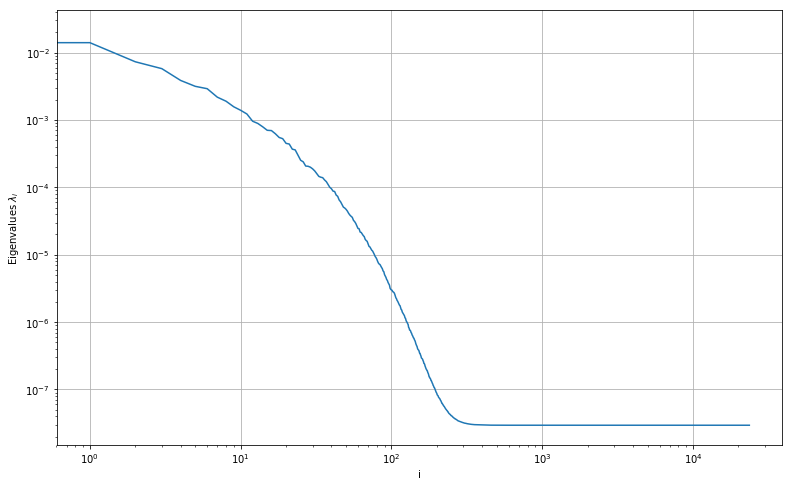

In [24]:
plt.figure(figsize=(13,8))
plt.loglog(eig_oas[::-1])
plt.grid()
plt.xlabel("i")
plt.ylabel("Eigenvalues $\lambda_i$")

# Shrunk Covariance

In [46]:
model = ShrunkCovariance(store_precision=True, assume_centered=False, shrinkage=0.8)

In [48]:
model.fit(Z[S,:].T)

ShrunkCovariance(assume_centered=False, shrinkage=0.8, store_precision=True)

In [49]:
cov_shrink = model.covariance_

In [50]:
np.linalg.slogdet(cov_shrink)

(1.0, -303046.2067669932)

In [51]:
eig_shrinkage_08 = np.linalg.eigvalsh(cov_shrink)

In [64]:
eig_oas[-1]

0.021723713807366964

In [ ]:
plt.figure(figsize=(13,8))
plt.loglog(eig_shrinkage_08[::-1])
plt.grid()
plt.xlabel("i")
plt.ylabel("Eigenvalues $\lambda_i$")

## PCA

In [36]:
model = PCA(n_components=40)

In [37]:
model.fit(Z[S,:].T)

PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [38]:
cov_pca = model.get_covariance()

In [39]:
np.linalg.slogdet(cov_pca)

(1.0, -314378.3192036518)

In [40]:
eig_pca = np.linalg.eigvalsh(cov_pca)

Text(0, 0.5, 'Eigenvalues $\\lambda_i$')

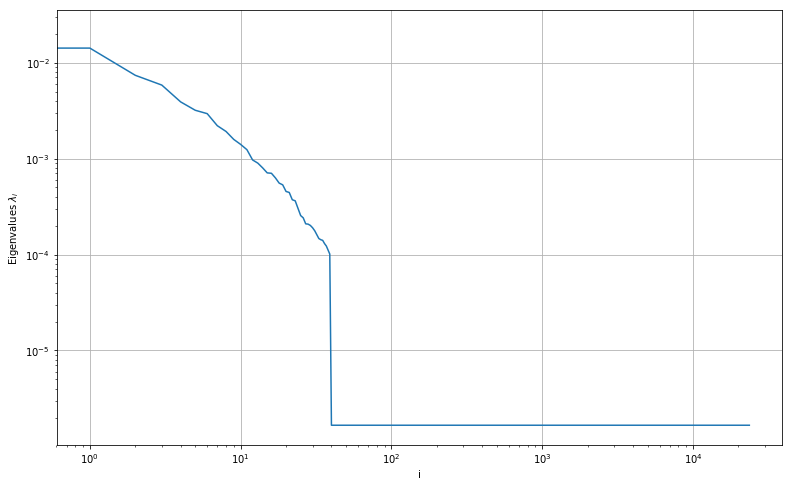

In [41]:
plt.figure(figsize=(13,8))
plt.loglog(eig_pca[::-1])
plt.grid()
plt.xlabel("i")
plt.ylabel("Eigenvalues $\lambda_i$")

## Comparison Plot

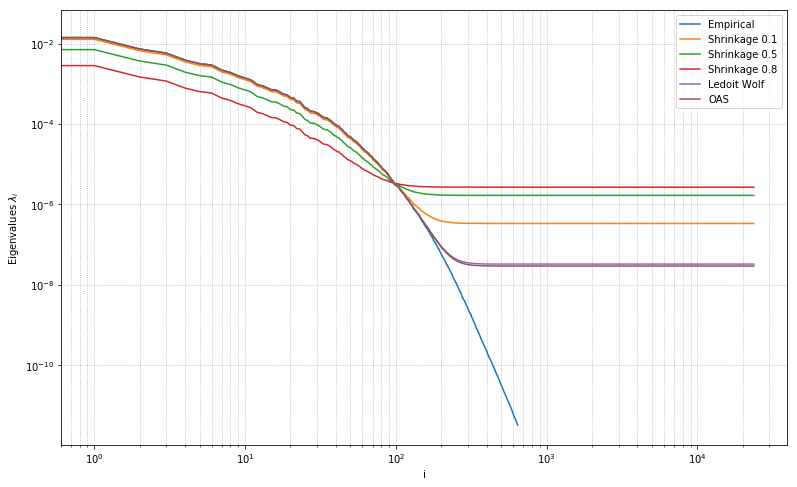

In [53]:
plt.figure(figsize=(13,8))
plt.loglog(eig_emp[23000:][::-1])
plt.loglog(eig_shrinkage[::-1])
plt.loglog(eig_shrinkage_05[::-1])
plt.loglog(eig_shrinkage_08[::-1])

plt.loglog(eig_ledoit[::-1])
plt.loglog(eig_oas[::-1])
#plt.loglog(eig_pca[::-1])
plt.grid(True,which="both",ls=":")
plt.xlabel("i")
plt.ylabel("Eigenvalues $\lambda_i$")
plt.legend(['Empirical', 'Shrinkage 0.1', 'Shrinkage 0.5', 'Shrinkage 0.8','Ledoit Wolf','OAS']) #,'PCA n=40'

## Finding Threshold 

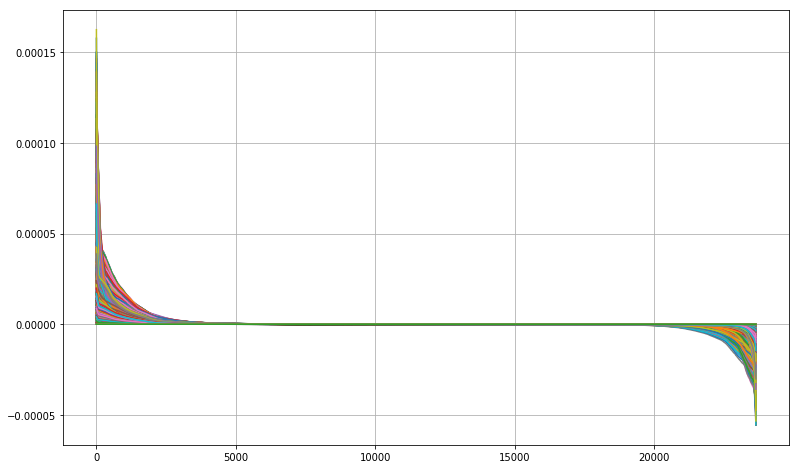

In [97]:
plt.figure(figsize=(13,8))
plt.plot(np.sort(cov_oas[0][:,:],axis=1)[:,::-1][:,:].T);
plt.grid()

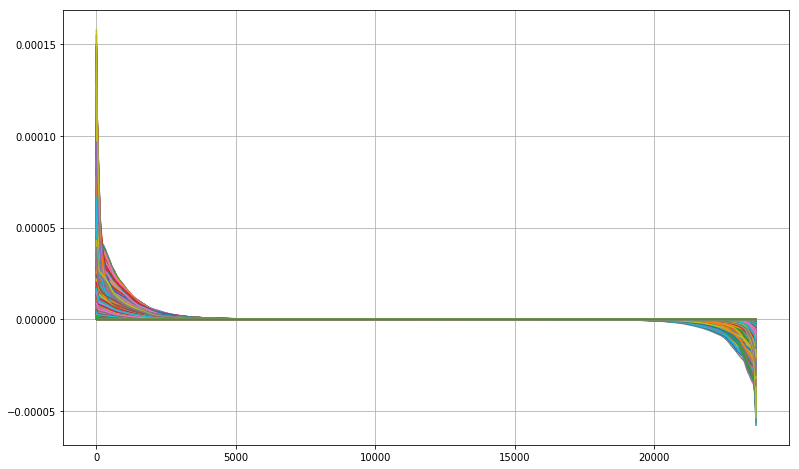

In [99]:
plt.figure(figsize=(13,8))
plt.plot(np.sort(cov_pca[:,:],axis=1)[:,::-1][:,:].T);
plt.grid()

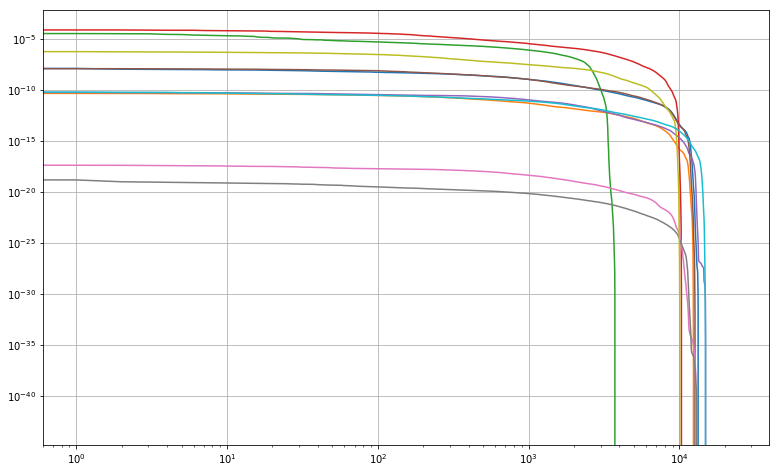

In [198]:
plt.figure(figsize=(13,8))
plt.loglog(np.sort(cov_pca[:10,:],axis=1)[:,::-1][:,:].T);
plt.grid()

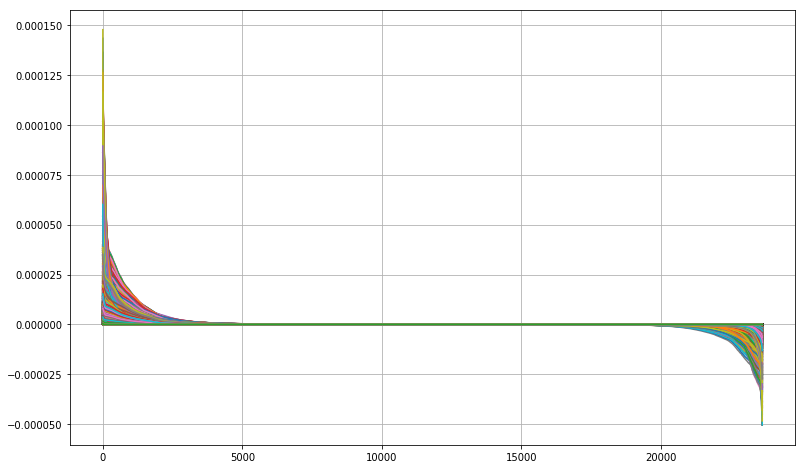

In [103]:
plt.figure(figsize=(13,8))
plt.plot(np.sort(cov_shrink[:,:],axis=1)[:,::-1][:,:].T);
plt.grid()

In [77]:
np.sort(cov_oas[0][0:10,:],axis=0)[:,::-1]

array([[-1.09359724e-21, -1.21315756e-21, -2.86196576e-19, ...,
        -1.26981376e-09, -7.73020912e-12, -1.26981376e-09],
       [-1.98808304e-22, -1.97136944e-22, -4.40232159e-23, ...,
        -9.33966931e-10, -8.05147016e-25, -7.55173027e-16],
       [-2.89847596e-23, -2.97426411e-23, -3.00347665e-25, ...,
        -7.73020912e-12, -9.27859284e-30, -8.76411801e-23],
       ...,
       [ 6.72407821e-40,  6.61677520e-40,  4.30470781e-23, ...,
         1.80585927e-07,  4.03122538e-13,  2.78924662e-11],
       [ 2.70585478e-35,  6.01906151e-35,  1.04164505e-20, ...,
         1.68260116e-06,  6.91716894e-12,  3.33832513e-09],
       [ 1.70836720e-27,  1.54818600e-27,  1.24967501e-18, ...,
         2.18794450e-05,  2.94350276e-08,  2.94410328e-08]])

In [ ]:
plt.pcolormesh(((cov_pca[:,:])))


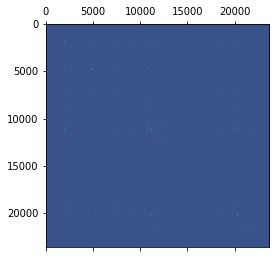

In [30]:
plt.matshow(cov)

In [52]:
np.linalg.norm(cov_np-cov_pca)

0.00019691706064742899

In [53]:
np.linalg.det(cov_pca)

0.0

### Sensor Optimisation with TSVD : 


Define the Sets for the optimisation

In [10]:
sets = define_sets(S)

Number of sensors to place : 

In [11]:
k = 5

Truncation parameteter for the TSVD : 

In [12]:
tau = 50

In [13]:
A_opt = {}

In [14]:
A_opt['lazy'] = sensor_loc_optimisation_lazy(k,Z, sets, tau)

Inner Loop:   0%|          | 62/57725 [02:48<42:11:34,  2.63s/it]

KeyboardInterrupt: 

In [ ]:
A_opt['naive'] = sensor_loc_optimisation_naive(k,Z, sets, tau)

In [ ]:
A_opt['lazy'] 

In [ ]:
A_opt['naive']

In [138]:
S = np.random.random_integers(0,300,size=(10,1))

In [139]:
n_S = len(S)

In [140]:
dict(zip(S.tolist(),[0]*10))

TypeError: unhashable type: 'list'

In [141]:
[0]*10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [142]:
S.tolist()

[[225], [230], [244], [112], [246], [28], [144], [238], [269], [213]]

In [146]:
delta_y = dict(zip(S.flatten().tolist(), np.zeros(n_S).tolist()))

In [147]:
delta_y[230] = 10

In [158]:
y_opt = max(delta_y, key=delta_y.get)

In [161]:
delta_y.pop(y_opt)

KeyError: 230

In [162]:
delta_y

{225: 0.0,
 244: 0.0,
 112: 0.0,
 246: 0.0,
 28: 0.0,
 144: 0.0,
 238: 0.0,
 269: 0.0,
 213: 0.0}

In [173]:
np.argsort(cov_oas[np.ix_([10], [10,11,12,13,14,15])].flatten())[::-1][:d].tolist()

TypeError: tuple indices must be integers or slices, not tuple

In [190]:
np.sort(cov_oas[0][np.ix_([10], [10,11,12,13,14,15,16,17,18])].flatten())[::-1][:]

array([ 3.04683018e-08,  1.59204220e-11,  3.92747823e-13,  1.05684794e-13,
        8.64823140e-14,  6.04891684e-15,  1.80171584e-16, -2.72473060e-11,
       -6.24891498e-09])

In [196]:
np.argsort(np.array([[-1],[40],[10]]).flatten())

array([0, 2, 1])

In [197]:
np.argsort(np.array([[-1],[40],[10]]).flatten())

array([0, 2, 1])

Space analysis 

In [210]:
volume = (loc_df.X.max() - loc_df.X.min() )* (loc_df.Y.max() - loc_df.Y.min()) *  (loc_df.Z.max() - loc_df.Z.min() )

In [214]:
print('Density of ', loc_df.shape[0] / volume, 'pts/m^3')

Density of  0.0008232349985215937 pts/m^3


In [253]:
%matplotlib notebook


In [ ]:
plt.figure(figsize=(13,8))
plt.scatter(loc_df.X, loc_df.Y, s=0.2);
plt.scatter(loc_df.X[sphere_central], loc_df.Y[sphere_central], s=0.2)

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [248]:
sphere_central = np.sqrt(loc_df.X**2 + loc_df.Y**2 + loc_df.Z**2) < 1

In [249]:
sphere_central.sum() / (2*np.pi*1**3/3)

0.47746482927568606

In [70]:
while True:
    pass

KeyboardInterrupt: 

In [92]:
yolo = loc_df.loc[[52731, 47876,  3078, 19782, 26045, 30511, 26754, 81507, 11608,
        3903],:].transpose().to_latex(float_format="%.2f")
print(yolo)

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  52731 &  47876 &  3078  &  19782 &  26045 &  30511 &  26754 &  81507 &  11608 &  3903  \\
\midrule
X &  61.31 &  43.55 &  77.31 &  38.75 &  48.23 &  50.48 &  52.36 &  43.10 &  82.40 &  62.01 \\
Y &  40.06 &  27.62 &  35.55 &  35.26 &  29.38 &  30.04 &  44.37 &  27.52 &  44.48 &  32.39 \\
Z &   1.52 &  16.40 &   1.45 &   1.80 &  19.53 &  11.79 &   1.62 &  10.23 &   1.96 &   0.20 \\
\bottomrule
\end{tabular}



\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &      52731 &      47876 &      3078  &      19782 &      26045 &      30511 &      26754 &      81507 &      11608 &      3903  \\
\midrule
X &  61.310795 &  43.546264 &  77.308928 &  38.747350 &  48.226689 &  50.477287 &  52.357477 &  43.103305 &  82.400982 &  62.005233 \\
Y &  40.056891 &  27.618026 &  35.551302 &  35.258986 &  29.375776 &  30.042716 &  44.367167 &  27.524777 &  44.476178 &  32.392064 \\
Z &   1.517226 &  16.401778 &   1.454437 &   1.799108 &  19.525959 &  11.790464 &   1.623817 &  10.228831 &   1.959180 &   0.200000 \\
\bottomrule
\end{tabular}



In [ ]:
pd.DataFrame.to_latex()